Used data instead of ms_data_train in train loader creation

TODO: possible increase learning rate

### \\\ Currently used ///

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
# use multiple GPUs
gpu = 4
multi_gpus = None#[0, 1, 2]
b = 4
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
train_h5 = h5py.File('/analysis/ritter/data/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/ritter/data/MS/CIS/holdout_dataset.h5', 'r')

In [9]:
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
X_train, y_train = train_h5['X'], train_h5['y']

In [10]:
# convert data to numpy arrays
#X_train = np.array(X_train, dtype=dtype)
#y_train = np.array(y_train)

#X_holdout = np.array(X_holdout, dtype=dtype)
#y_holdout = np.array(y_holdout)

In [11]:
class MSDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
            
        sample = {"image" : image,
                 "label" : label}
                 #"idx":idx}
        return sample

In [12]:
if zero_one_normalize:
    intensity = IntensityRescale()
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

In [13]:
sample = ms_data_train[29]
img = sample["image"]

In [14]:
img.shape

torch.Size([1, 96, 114, 96])

Text(0.5, 1.0, '1.0')

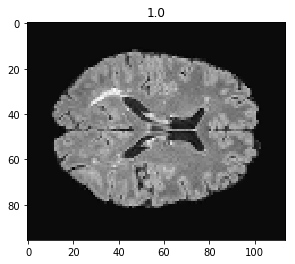

In [15]:
plt.imshow(img[0][:,:,46], cmap='gray')
plt.title(sample["label"].item())

# Define the classifier

In [16]:
class PatchIndividualFilters3D(Module):
    def __init__(self, input_dim, filter_shape, patch_shape, num_local_filter_in, num_local_filter_out, debug=0):
        super(PatchIndividualFilters3D, self).__init__()
        self.input_dim = input_dim  # expects it to be a 3D vector
        self.filter_shape = filter_shape
        self.patch_shape = patch_shape
        self.num_local_filter_out = num_local_filter_out
        self.num_local_filter_in = num_local_filter_in

        # calc padding and num_patches
        self.padding_dim = [0] * len(self.input_dim) * 2
        # initialize all local convs with weight & co
        self.num_patches, self.num_patches_per_dim = self.calc_pad_dim_num_patches()

        self.conv_dict = {}
        for patch in range(self.num_patches):
            # initialize convolution object
            self.add_module("conv_{}".format(patch),
                            nn.Conv3d(self.num_local_filter_in, self.num_local_filter_out, self.filter_shape, stride=1))
            # initialize activation object
            self.add_module("activ_{}".format(patch),
                            nn.ELU())
            

        self.grads = {}
        self.debug = debug

    def save_grad(self, name):

        def hook(grad):
            self.grads[name] = grad

        return hook

    def calc_pad_dim_num_patches(self):
        # initialize
        num_patches = 1
        num_patches_per_dim = [0] * len(self.input_dim)

        # check if patch_shape fits input dimension
        for idx, dim in enumerate(self.patch_shape):
            tmp_remain = self.input_dim[idx] % dim
            tmp_division = self.input_dim[idx] // dim
            if tmp_remain != 0:
                # how much we need to add sch that patch_shape fits perfectly
                self.padding_dim[idx * 2] = dim - tmp_remain
                tmp_division += 1
            num_patches_per_dim[idx] = tmp_division
            num_patches = num_patches * tmp_division
        return num_patches, num_patches_per_dim

    def pad_to_batch_size(self, input):
        # expects input to be a 5D vector!

        # pad input
        if sum(self.padding_dim):
            # add batch and channel dimension, each twice, to padding dim
            pad_dim = [0, 0, 0, 0] + self.padding_dim

            # use constant pad (caution: last dimension first!)
            input = torch.nn.functional.pad(input, pad_dim[::-1], mode='constant', value=0)

        if self.debug:
            input.register_hook(self.save_grad("post_padding"))

        return input

    def split_5d(self, input):
        # get batch size of input
        bs = input.shape[0]
        # initialize
        splits = []
        # loop over batch and filter and split each "input"
        for batch in range(bs):
            splits_filter = []
            for filter in range(self.num_local_filter_in):
                feature_map_in = input[batch, filter]
                # get chunks back from feature map ("input")
                t = self.get_chunks(feature_map_in)
                # append chunk dimension
                t = [torch.unsqueeze(x, 0) for x in t]
                # cat along chunk dimension
                t = torch.cat(t, 0)
                # add to filter list
                splits_filter += [t]
            # append filter dimension
            splits_filter = [torch.unsqueeze(x, 0) for x in splits_filter]
            # cat along filter dimension
            splits_filter = torch.cat(splits_filter, 0)
            splits += [splits_filter]
        # append batch dimension
        splits = [torch.unsqueeze(x, 0) for x in splits]
        # finally cat along that dimension
        splits = torch.cat(splits, 0)

        if self.debug:
            input.register_hook(self.save_grad("post_reshape"))

        return splits, bs  # a 6D vector

    def get_chunks(self, ddd_input):
        ddd_input_shape = ddd_input.shape
        tns = [ddd_input]
        # for every dimension in 3d input we split according to dimension and number of desired patches
        for id, dim in enumerate(ddd_input_shape):
            tns_tmp = []
            for tnsr in tns:
                # determine how to split the tensor.
                # Example:
                # dimension is 4: 2 batches desired in that dimension -> split dimension in [2,2]
                # dimension is 4: 4 batches desired in that dimension -> split dimension in [1,1,1,1]
                dim_x_split_size = [int(dim / self.num_patches_per_dim[id])] * self.num_patches_per_dim[id]
                # print("dim: " + str(dim))
                # print("num_patches: " + str(self.num_patches_per_dim))
                # print("dim_split_size: " + str(dim_x_split_size))
                tmp = torch.split(tnsr, dim_x_split_size, id)
                tns_tmp += list(tmp)
            tns = tns_tmp
        return tns

    def call_conv(self, idx, patch):

        if self.debug:
            patch.register_hook(self.save_grad("pre_convol_{}".format(idx)))

        # apply convolution
        c_res = getattr(self, "conv_{}".format(idx))(patch)
        # apply activation
        c_res = getattr(self, "activ_{}".format(idx))(c_res)

        if self.debug:
            c_res.register_hook(self.save_grad("post_conv_{}".format(idx)))

        # add 6th dimension at 2. place for later cat
        c_res = c_res.unsqueeze(2)

        if self.debug:
            c_res.register_hook(self.save_grad("post_usqz_c_{}".format(idx)))

        return c_res

    def forward(self, input):

        # set hook to save gradient in debug mode
        if self.debug:
            input.register_hook(self.save_grad("backward_out"))

        # do reshape here!
        input = self.pad_to_batch_size(input)

        # reshape
        input, bs = self.split_5d(input)

        patch_out = []
        for idx in range(self.num_patches):
            # get patch
            patch = input[:, :, idx]  # get each patch (3nd Dimension of 6D vector)
            # do separate convolutions with each 5D vector!
            patch_out += [self.call_conv(idx, patch)]

        # concat to get 6D vector back
        out = torch.cat(patch_out, dim=2)

        # # put together
        # f_out = []
        # feature_out_dim = out.shape[-3:]
        # for filter in range(self.num_local_filter_out):
        #     filter_patch = []
        #     for patch in range(self.num_patches):
        #         y = out[patch, :, filter]
        #         filter_patch.append(y)
        #     z = torch.cat(filter_patch)
        #     z = z.view((bs,) + tuple([x * self.num_patches_per_dim[id] for id, x in enumerate(feature_out_dim)]))
        #     f_out.append(z)
        # out = torch.cat(f_out).unsqueeze(0)
        # out = out.view((bs, self.num_local_filter_out) + tuple([x * self.num_patches_per_dim[id] for id, x in enumerate(feature_out_dim)]))

        if self.debug:
            out.register_hook(self.save_grad("backward_in"))

        return out

In [17]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([10,13,10],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=3,
                                            debug=False)

        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            nn.Linear(972, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = F.dropout3d(self.pool_1(x), p=self.drp_rate)
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = F.dropout3d(self.pool_2(x), p=self.drp_rate)
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        #h = F.dropout3d(self.pool_4(x), p=self.drp_rate)
        #if print_size:
        #    print(h.shape)
    
        h = self.pif(x)
    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [18]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [19]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 493405


# Training

In [20]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      

    #kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
    #kf = KFold(n_splits=k_folds, shuffle=True)
    all_indices = list(range(len(data)))
    train_idx, val_idx = train_test_split(all_indices, test_size=0.1, random_state=12)
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        print("Shuffled the data..")

        # Note: is the dataset loading necessary again?
        if zero_one_normalize:
            intensity = IntensityRescale()
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        train_loader = DataLoader(
            ms_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            ms_data_train, batch_size=1, num_workers=1, sampler=val_sampler
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [21]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [22]:
#r = 0

In [23]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),

#augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [24]:
callbacks = [EarlyStopping(patience=16, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]
#callbacks = []

Starting trial 0
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


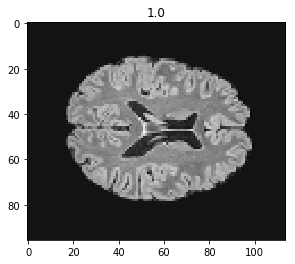

[0,    20] loss: 0.70289
Time elapsed: 0h:0m:13s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.84 %
val accuracy_score: 69.23 %
val balanced_accuracy: 50.00 %
Val loss: 0.678675
[1,    20] loss: 0.69721
Time elapsed: 0h:0m:27s
train accuracy_score: 51.35 %
train balanced_accuracy: 51.96 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.708546
[2,    20] loss: 0.69787
Time elapsed: 0h:0m:41s
train accuracy_score: 46.85 %
train balanced_accuracy: 46.69 %
val accuracy_score: 61.54 %
val balanced_accuracy: 44.44 %
Val loss: 0.689721
[3,    20] loss: 0.69320
Time elapsed: 0h:0m:55s
train accuracy_score: 47.75 %
train balanced_accuracy: 46.06 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.700287
[4,    20] loss: 0.69507
Time elapsed: 0h:1m:9s
train accuracy_score: 47.75 %
train balanced_accuracy: 45.94 %
val accuracy_score: 69.23 %
val balanced_accuracy: 50.00 %
Val loss: 0.685599
[5,    20] loss: 0.69237
Time elapsed: 0h:1m:22s
tr

[43,    20] loss: 0.10618
Time elapsed: 0h:10m:14s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.34 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.946559
Early stopping in epoch 44
Total time elapsed: 0h:10m:14s
Finished fold.


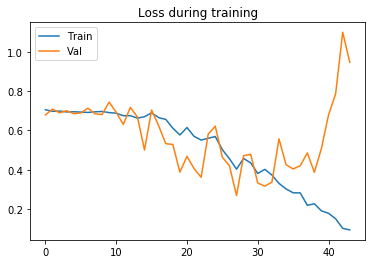

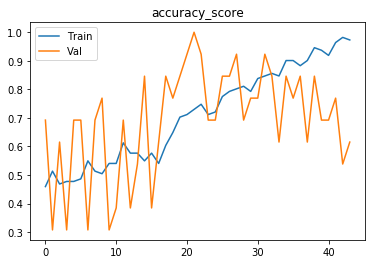

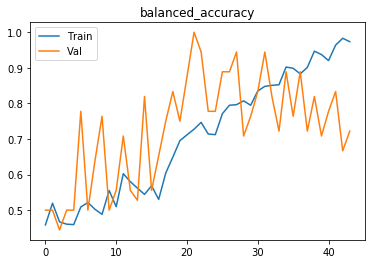

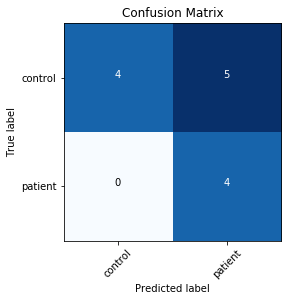

Starting trial 1
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


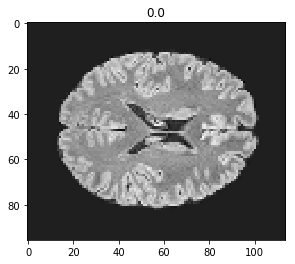

[0,    20] loss: 0.69556
Time elapsed: 0h:0m:13s
train accuracy_score: 51.35 %
train balanced_accuracy: 51.27 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.765810
[1,    20] loss: 0.70335
Time elapsed: 0h:0m:27s
train accuracy_score: 39.64 %
train balanced_accuracy: 40.25 %
val accuracy_score: 46.15 %
val balanced_accuracy: 40.28 %
Val loss: 0.693973
[2,    20] loss: 0.69801
Time elapsed: 0h:0m:41s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.54 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.696451
[3,    20] loss: 0.69823
Time elapsed: 0h:0m:55s
train accuracy_score: 41.44 %
train balanced_accuracy: 42.41 %
val accuracy_score: 53.85 %
val balanced_accuracy: 45.83 %
Val loss: 0.693493
[4,    20] loss: 0.69452
Time elapsed: 0h:1m:9s
train accuracy_score: 48.65 %
train balanced_accuracy: 47.36 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.699280
[5,    20] loss: 0.69750
Time elapsed: 0h:1m:22s
tr

[43,    20] loss: 0.08358
Time elapsed: 0h:10m:10s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.34 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.407521
[44,    20] loss: 0.15520
Time elapsed: 0h:10m:24s
train accuracy_score: 92.79 %
train balanced_accuracy: 92.99 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.115764
[45,    20] loss: 0.06700
Time elapsed: 0h:10m:41s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.19 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.073349
[46,    20] loss: 0.04228
Time elapsed: 0h:10m:58s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.34 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.491127
[47,    20] loss: 0.08909
Time elapsed: 0h:11m:12s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.27 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.072970
[48,    20] loss: 0.05033
Time ela

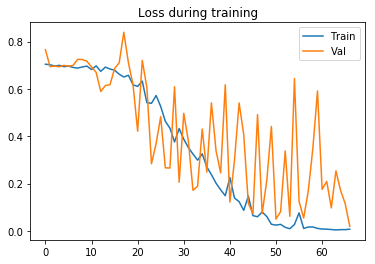

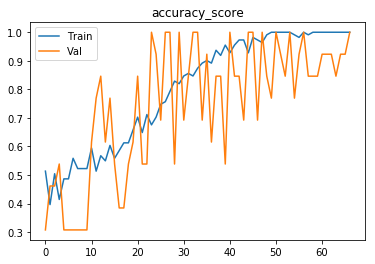

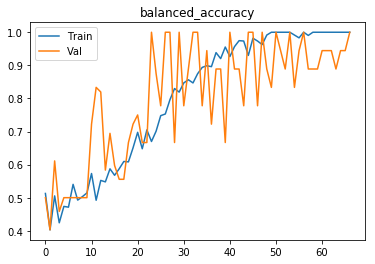

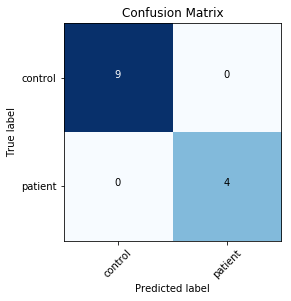

Starting trial 2
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


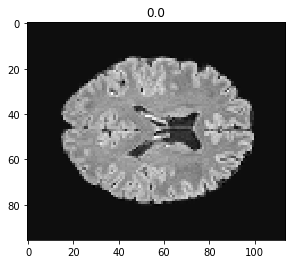

[0,    20] loss: 0.69590
Time elapsed: 0h:0m:13s
train accuracy_score: 48.65 %
train balanced_accuracy: 47.02 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.704042
[1,    20] loss: 0.69731
Time elapsed: 0h:0m:26s
train accuracy_score: 57.66 %
train balanced_accuracy: 55.15 %
val accuracy_score: 46.15 %
val balanced_accuracy: 54.17 %
Val loss: 0.692743
[2,    20] loss: 0.69780
Time elapsed: 0h:0m:39s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.61 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.697679
[3,    20] loss: 0.69000
Time elapsed: 0h:0m:52s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.710460
[4,    20] loss: 0.69054
Time elapsed: 0h:1m:6s
train accuracy_score: 59.46 %
train balanced_accuracy: 56.84 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.704955
[5,    20] loss: 0.69369
Time elapsed: 0h:1m:20s
tr

[43,    20] loss: 0.02330
Time elapsed: 0h:10m:15s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.04 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.453856
[44,    20] loss: 0.04657
Time elapsed: 0h:10m:29s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.19 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.794694
[45,    20] loss: 0.01224
Time elapsed: 0h:10m:43s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.898938
[46,    20] loss: 0.02457
Time elapsed: 0h:10m:56s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.390568
[47,    20] loss: 0.01426
Time elapsed: 0h:11m:12s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 1.377505
[48,    20] loss: 0.02056
Time ela

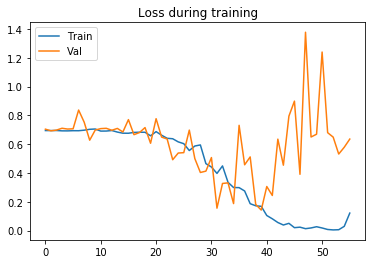

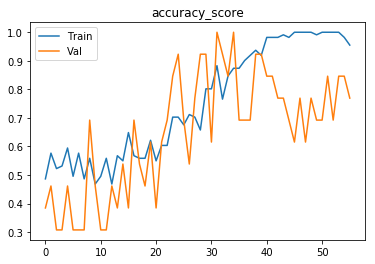

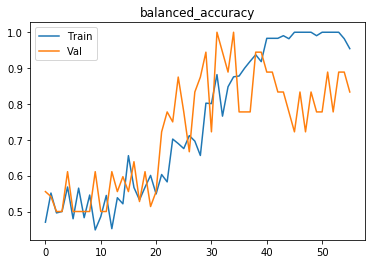

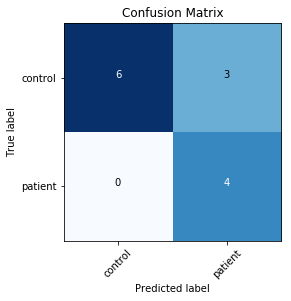

Starting trial 3
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


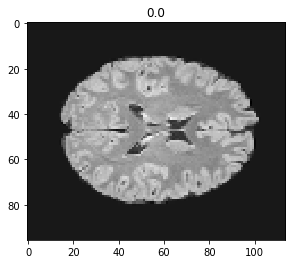

[0,    20] loss: 0.69215
Time elapsed: 0h:0m:13s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.711129
[1,    20] loss: 0.69376
Time elapsed: 0h:0m:27s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.709889
[2,    20] loss: 0.69307
Time elapsed: 0h:0m:41s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.700118
[3,    20] loss: 0.69330
Time elapsed: 0h:0m:55s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.96 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.710738
[4,    20] loss: 0.68759
Time elapsed: 0h:1m:9s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.708909
[5,    20] loss: 0.68673
Time elapsed: 0h:1m:23s
tr

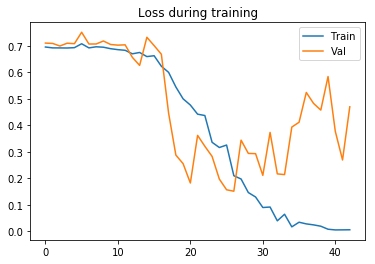

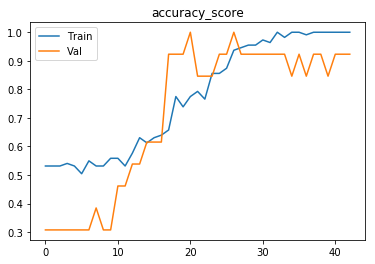

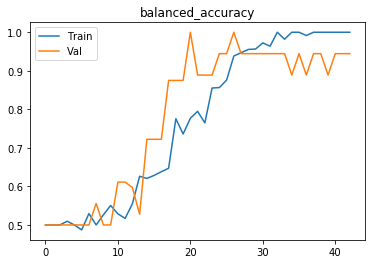

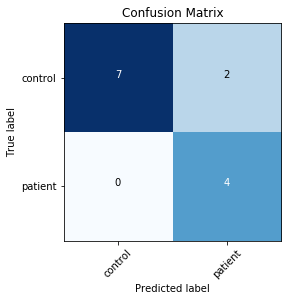

Starting trial 4
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


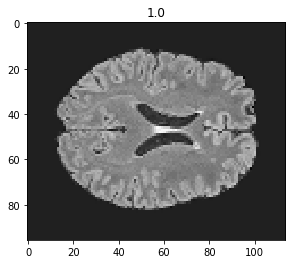

[0,    20] loss: 0.69858
Time elapsed: 0h:0m:13s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.96 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.711479
[1,    20] loss: 0.69274
Time elapsed: 0h:0m:27s
train accuracy_score: 44.14 %
train balanced_accuracy: 46.66 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.693974
[2,    20] loss: 0.70231
Time elapsed: 0h:0m:41s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.18 %
val accuracy_score: 69.23 %
val balanced_accuracy: 50.00 %
Val loss: 0.682151
[3,    20] loss: 0.69685
Time elapsed: 0h:0m:55s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.16 %
val accuracy_score: 30.77 %
val balanced_accuracy: 43.06 %
Val loss: 0.694544
[4,    20] loss: 0.69699
Time elapsed: 0h:1m:9s
train accuracy_score: 46.85 %
train balanced_accuracy: 49.09 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.687952
[5,    20] loss: 0.69570
Time elapsed: 0h:1m:23s
tr

[43,    20] loss: 0.01735
Time elapsed: 0h:10m:19s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.578999
[44,    20] loss: 0.01532
Time elapsed: 0h:10m:32s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.168040
[45,    20] loss: 0.03154
Time elapsed: 0h:10m:45s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.266487
[46,    20] loss: 0.02096
Time elapsed: 0h:10m:59s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.865422
[47,    20] loss: 0.01051
Time elapsed: 0h:11m:13s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.593473
[48,    20] loss: 0.01509
Time ela

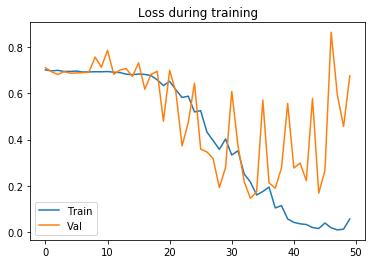

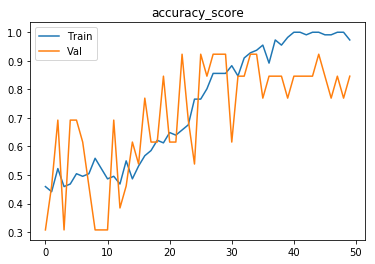

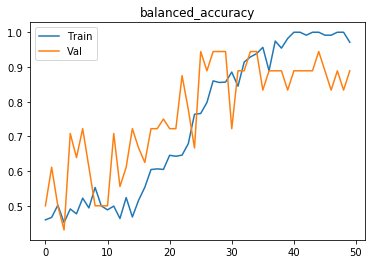

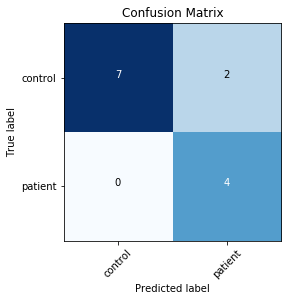

Starting trial 5
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


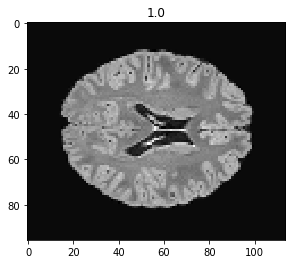

[0,    20] loss: 0.69484
Time elapsed: 0h:0m:14s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.713473
[1,    20] loss: 0.69777
Time elapsed: 0h:0m:30s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.750596
[2,    20] loss: 0.69242
Time elapsed: 0h:0m:44s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.716285
[3,    20] loss: 0.68839
Time elapsed: 0h:0m:59s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.23 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.690113
[4,    20] loss: 0.69189
Time elapsed: 0h:1m:13s
train accuracy_score: 53.15 %
train balanced_accuracy: 52.74 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.688268
[5,    20] loss: 0.68942
Time elapsed: 0h:1m:27s
t

[43,    20] loss: 0.09385
Time elapsed: 0h:10m:25s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.614430
[44,    20] loss: 0.04120
Time elapsed: 0h:10m:39s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.287644
[45,    20] loss: 0.01759
Time elapsed: 0h:10m:53s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.505175
[46,    20] loss: 0.01693
Time elapsed: 0h:11m:7s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.294662
[47,    20] loss: 0.01329
Time elapsed: 0h:11m:20s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.074938
[48,    20] loss: 0.06400
Time el

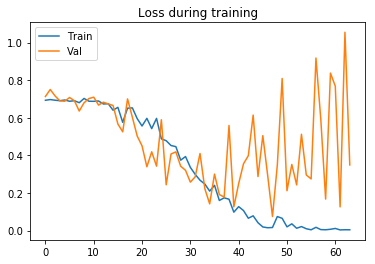

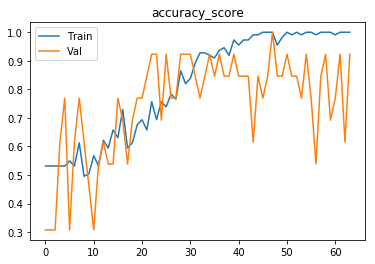

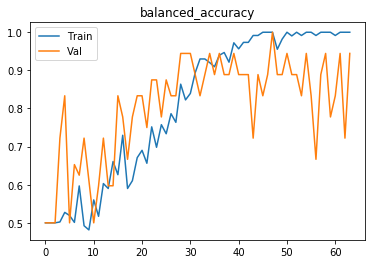

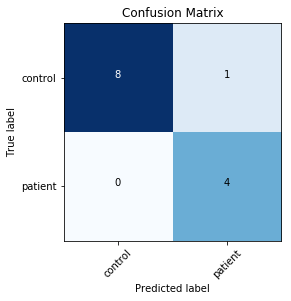

Starting trial 6
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


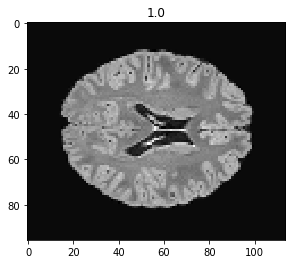

[0,    20] loss: 0.69558
Time elapsed: 0h:0m:13s
train accuracy_score: 54.05 %
train balanced_accuracy: 51.53 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.712896
[1,    20] loss: 0.69271
Time elapsed: 0h:0m:28s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.38 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.707001
[2,    20] loss: 0.69150
Time elapsed: 0h:0m:45s
train accuracy_score: 54.95 %
train balanced_accuracy: 53.86 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.705269
[3,    20] loss: 0.69450
Time elapsed: 0h:1m:2s
train accuracy_score: 54.95 %
train balanced_accuracy: 52.04 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.687801
[4,    20] loss: 0.69381
Time elapsed: 0h:1m:16s
train accuracy_score: 54.95 %
train balanced_accuracy: 53.18 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.797526
[5,    20] loss: 0.69900
Time elapsed: 0h:1m:30s
tr

[43,    20] loss: 0.08779
Time elapsed: 0h:10m:30s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.38 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.943002
[44,    20] loss: 0.07316
Time elapsed: 0h:10m:44s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.19 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.510373
[45,    20] loss: 0.03017
Time elapsed: 0h:10m:59s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.04 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.153792
[46,    20] loss: 0.02024
Time elapsed: 0h:11m:12s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.160264
[47,    20] loss: 0.00581
Time elapsed: 0h:11m:26s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.515232
[48,    20] loss: 0.00370
Time elaps

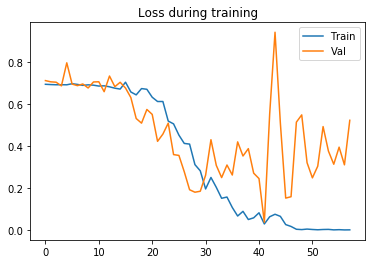

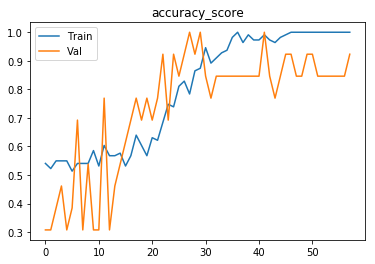

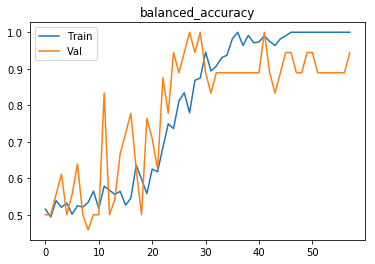

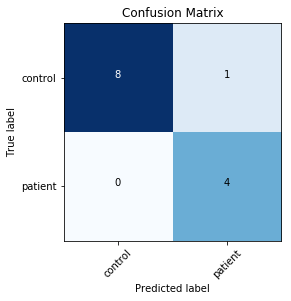

Starting trial 7
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


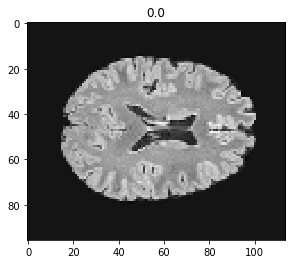

[0,    20] loss: 0.69823
Time elapsed: 0h:0m:12s
train accuracy_score: 43.24 %
train balanced_accuracy: 45.01 %
val accuracy_score: 30.77 %
val balanced_accuracy: 43.06 %
Val loss: 0.696593
[1,    20] loss: 0.69827
Time elapsed: 0h:0m:26s
train accuracy_score: 46.85 %
train balanced_accuracy: 46.81 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.703777
[2,    20] loss: 0.69405
Time elapsed: 0h:0m:40s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.33 %
val accuracy_score: 69.23 %
val balanced_accuracy: 50.00 %
Val loss: 0.678355
[3,    20] loss: 0.69440
Time elapsed: 0h:0m:53s
train accuracy_score: 50.45 %
train balanced_accuracy: 51.11 %
val accuracy_score: 76.92 %
val balanced_accuracy: 69.44 %
Val loss: 0.689564
[4,    20] loss: 0.69528
Time elapsed: 0h:1m:7s
train accuracy_score: 52.25 %
train balanced_accuracy: 53.49 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.708680
[5,    20] loss: 0.69803
Time elapsed: 0h:1m:22s
tr

[43,    20] loss: 0.00205
Time elapsed: 0h:10m:15s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.653447
[44,    20] loss: 0.00814
Time elapsed: 0h:10m:29s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 1.243551
[45,    20] loss: 0.00625
Time elapsed: 0h:10m:44s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.472674
[46,    20] loss: 0.00736
Time elapsed: 0h:10m:59s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 1.144795
[47,    20] loss: 0.00618
Time elapsed: 0h:11m:13s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 1.106867
[48,    20] loss: 0.01180
Time

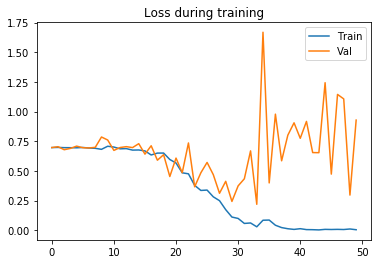

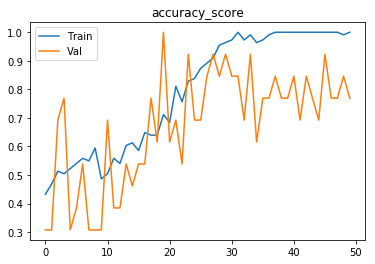

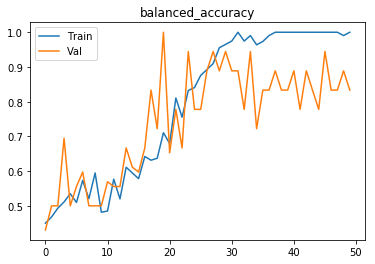

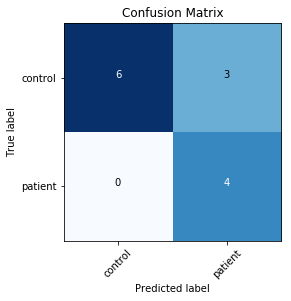

Starting trial 8
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


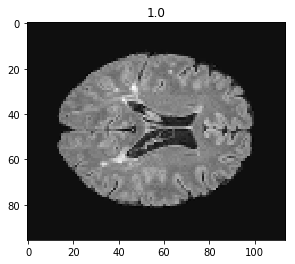

[0,    20] loss: 0.69718
Time elapsed: 0h:0m:13s
train accuracy_score: 44.14 %
train balanced_accuracy: 44.38 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.735216
[1,    20] loss: 0.69539
Time elapsed: 0h:0m:27s
train accuracy_score: 47.75 %
train balanced_accuracy: 46.51 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.695752
[2,    20] loss: 0.69675
Time elapsed: 0h:0m:41s
train accuracy_score: 49.55 %
train balanced_accuracy: 48.32 %
val accuracy_score: 38.46 %
val balanced_accuracy: 48.61 %
Val loss: 0.704737
[3,    20] loss: 0.70054
Time elapsed: 0h:0m:55s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.10 %
val accuracy_score: 69.23 %
val balanced_accuracy: 63.89 %
Val loss: 0.685360
[4,    20] loss: 0.69531
Time elapsed: 0h:1m:9s
train accuracy_score: 48.65 %
train balanced_accuracy: 49.87 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.703952
[5,    20] loss: 0.69199
Time elapsed: 0h:1m:23s
tr

[43,    20] loss: 0.16219
Time elapsed: 0h:10m:16s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.92 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.191493
[44,    20] loss: 0.06854
Time elapsed: 0h:10m:31s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.50 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.821068
[45,    20] loss: 0.11010
Time elapsed: 0h:10m:45s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.65 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.779701
[46,    20] loss: 0.08195
Time elapsed: 0h:10m:59s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.08 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.222732
[47,    20] loss: 0.11823
Time elapsed: 0h:11m:13s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.42 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.343448
[48,    20] loss: 0.05315
Time elapsed

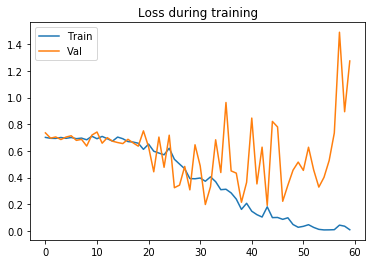

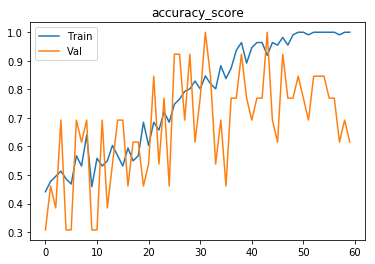

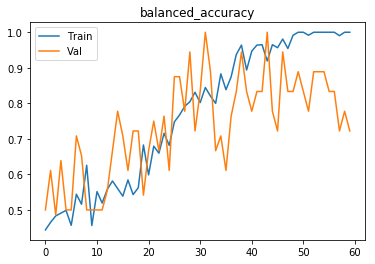

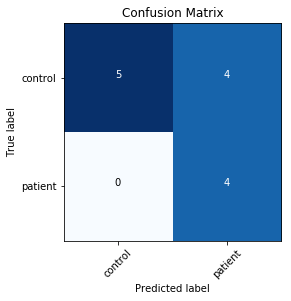

Starting trial 9
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


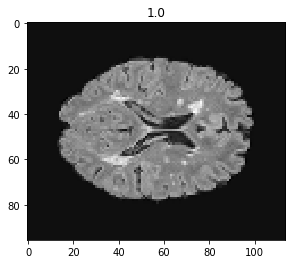

[0,    20] loss: 0.69259
Time elapsed: 0h:0m:13s
train accuracy_score: 50.45 %
train balanced_accuracy: 47.69 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.718756
[1,    20] loss: 0.69301
Time elapsed: 0h:0m:29s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.702414
[2,    20] loss: 0.69345
Time elapsed: 0h:0m:43s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.53 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.697225
[3,    20] loss: 0.69081
Time elapsed: 0h:0m:58s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.03 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.78 %
Val loss: 0.683667
[4,    20] loss: 0.70314
Time elapsed: 0h:1m:11s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.33 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.710663
[5,    20] loss: 0.69070
Time elapsed: 0h:1m:26s
t

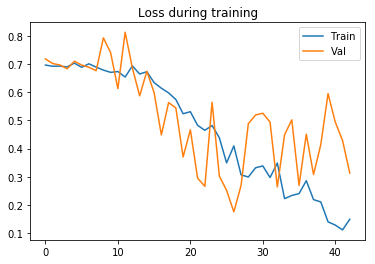

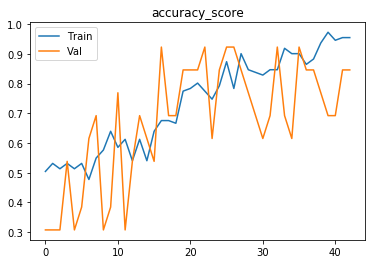

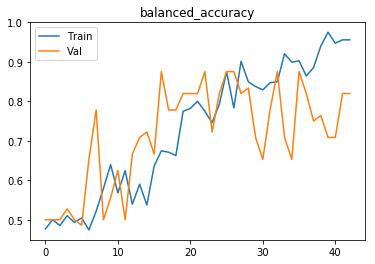

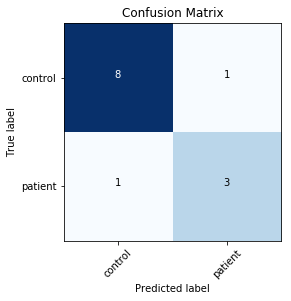

################################
################################
All accuracies: [0.7222222222222222, 1.0, 0.8333333333333333, 0.9444444444444444, 0.8888888888888888, 0.9444444444444444, 0.9444444444444444, 0.8333333333333333, 0.7222222222222222, 0.8194444444444444]
0.8652777777777777
0.09087409890530884


In [25]:
fold_metric, models = run(net=net, data=ms_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [26]:
5/0

ZeroDivisionError: division by zero

# Start inference

In [27]:
test_loader = DataLoader(
            ms_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [28]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.6230769230769231
Fold 1
0.773076923076923
Fold 2
0.8
Fold 3
0.95
Fold 4
0.85
Fold 5
0.85
Fold 6
0.85
Fold 7
0.7615384615384615
Fold 8
0.8115384615384615
Fold 9
0.823076923076923
######## Final results ########
          0
0  0.623077
1  0.773077
2  0.800000
3  0.950000
4  0.850000
5  0.850000
6  0.850000
7  0.761538
8  0.811538
9  0.823077
Balanced accuracy mean 80.92 %


In [ ]:

# load holdout set
df = pd.read_csv(doc_dir)
df = df.loc[indices_holdout]

metrics = []
callbacks = []

criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0)

if zero_one_normalize:
    test_transforms = transforms.Compose([intensity, ToTensor()])
else:
    test_transforms = transforms.Compose([ToTensor()])
    
cis_data_test = CISDataset(X_holdout, y_holdout, transform=test_transforms, mask=mask, dtype=dtype)
test_loader = DataLoader(
    cis_data_test, batch_size=4, num_workers=2, shuffle=True
        )

In [ ]:
cis_data[4]["image"].dtype

In [ ]:
next(iter(test_loader))["image"].dtype

In [ ]:
model_dirs = [os.path.join(output_dir, "repeat_0_cv_fold_6_training_epoch_28_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_5_training_epoch_87_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_4_training_epoch_30_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_3_training_epoch_40_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_2_training_epoch_30_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_1_training_epoch_25_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_0_training_epoch_32_FINAL.h5")]

In [ ]:
model_dirs = [os.path.join(output_dir,"repeat_0_cv_fold_{}_BEST_ITERATION.h5".format(i)) for i in range(7)]
metrics = []
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))
    
    # load pre-trained model
    #net = SixtyFourNet().cuda(gpu)
    net = serialize_model(net, model_dir)

    trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])
    
    metrics.append(computed_metrics)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df["balanced_accuracy"])*100))


In [ ]:
for i, m in enumerate(models):
    print(i)
    for param in m.parameters():
        print(param.grad.norm(2))

In [ ]:
all_weight_norms = {}
all_bias_norms = {}
for i, m in enumerate(models):
    bias_norms = {}
    weight_norms = {}
    print(i)
    for name, param in m.named_parameters():
        #norms.append(param.grad.norm(2))
        norm = param.grad.norm(2)
        if name.endswith("bias"):
            name = name.replace(".bias", "")
            bias_norms["layer_{}".format(name)] = norm
        elif name.endswith("weight"):
            name = name.replace(".weight", "")
            weight_norms["layer_{}".format(name)] = norm
    all_weight_norms["fold_{}".format(i)] = weight_norms
    all_bias_norms["fold_{}".format(i)] = bias_norms

In [ ]:
list(metrics_df["balanced_accuracy"])

In [ ]:
num_cols = 2
num_rows = 4
plt.figure()
c = 1
r = 1

plt.figure(figsize=(12, 24))
plt.subplots_adjust(hspace=0.9, wspace=0.2)
for f in range(len(models)):
    plt.subplot(num_rows, num_cols, f+1)
    plt.plot(*zip(*sorted(all_weight_norms["fold_{}".format(f)].items())))
    plt.plot(*zip(*sorted(all_bias_norms["fold_{}".format(f)].items())))
    plt.legend(["Weights", "Biases"])
    plt.title("Fold {} Test balanced acc {:.2f}".format(f, metrics_df["balanced_accuracy"][f]))
    plt.xticks(rotation=90)
    axes = plt.gca()
    axes.set_ylim([0, 1])
    c += 1
plt.show()
    